In [1]:
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import tensorflow as tf
import uproot
import hist

import zfit
from zfit import z

mplhep.style.use("CMS")
mplhep.style.use(
    {
        "figure.figsize": (6.4, 4.8),
        "font.size": 14,
        "legend.title_fontsize": 14,
        "savefig.bbox": "tight",
    }
)

/Users/iason/miniforge3/envs/work/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


727686.0


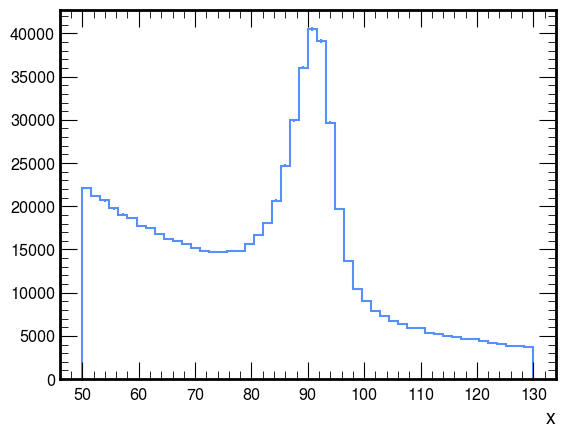

In [2]:
events = uproot.dask({"tnptuples/data_EGamma_Run2022D.root": "tnpEleTrig/fitter_tree"})
# probe_events = events[
#     (events.passingMVA122Xwp90isoV1 == 0)
#     & (events.el_pt > 30)
#     & (events.el_pt < 40)
#     & (abs(events.el_eta) < 1.44)
# ]
probe_events = events[events.passingMVA122Xwp90isoV1 == 0]
# probe_events = events
h = hist.Hist.new.Regular(50, 50, 130, name="x").Double()
h.fill(probe_events.pair_mass.compute())
h.plot1d()
print(h.sum())

In [3]:
class MyGauss(zfit.pdf.BasePDF):

    def __init__(self, mean, std, obs, extended=None, norm=None, name=None):
        params = {
            "mean": mean,  # 'mean' is the name as it will be named in the PDF, mean is just the parameter to create the PDF
            "std": std,
        }
        super().__init__(
            obs=obs, params=params, extended=extended, norm=norm, name=name
        )

    def _unnormalized_pdf(self, x):
        x = x.unstack_x()
        mean = self.params["mean"]
        std = self.params["std"]
        return tf.math.exp(-(((x - mean) / std) ** 2))

In [4]:
# create space
data = zfit.data.BinnedData.from_hist(h)
obs_binned = data.space
obs = obs_binned.with_binning(None)

# parameters
mu = zfit.Parameter("mu", 90.0, 85.0, 95.0)
sigma = zfit.Parameter("sigma", 5.0, 0.1, 10.0)
alphal = zfit.Parameter("alphal", 1.0, 0.1, 20.0)
nl = zfit.Parameter("nl", 5.0, 0.1, 20.0)
alphar = zfit.Parameter("alphar", 1.0, 0.1, 20.0)
nr = zfit.Parameter("nr", 5.0, 0.1, 20.0)
lambd = zfit.Parameter("lambda", -0.01, -0.1, -0.0)
n_bkg = zfit.Parameter("n_bkg", h.sum() * (1 - 0.3), 0, h.sum())
n_sig = zfit.Parameter("n_sig", h.sum() * 0.3, 0, h.sum())

# model building, pdf creation
# sig_pdf = MyGauss(mean=mu, std=sigma, obs=obs, extended=n_sig)
# sig_pdf = zfit.pdf.Gauss(
#     mu=mu,
#     sigma=sigma,
#     obs=obs,
#     extended=n_sig,
# )
sig_pdf = zfit.pdf.DoubleCB(
    mu=mu,
    sigma=sigma,
    alphal=alphal,
    nl=nl,
    alphar=alphar,
    nr=nr,
    obs=obs,
    extended=n_sig,
)
bkg_pdf = zfit.pdf.Exponential(lambd, obs=obs, extended=n_bkg)

model_unbinned = zfit.pdf.SumPDF([sig_pdf, bkg_pdf])

# make binned
model = model_unbinned.to_binned(obs_binned)

In [5]:
n_bins = 50
n_sample = h.sum()
plot_scaling = n_sample / n_bins * obs.area()
x = np.linspace(50, 130, 1000)


def plot_pdf(title):
    plt.figure()
    # plt.title(title)
    y = model_unbinned.pdf(x).numpy()
    y_gauss = (sig_pdf.pdf(x) * model_unbinned.params["frac_0"]).numpy()
    y_exp = (bkg_pdf.pdf(x) * model_unbinned.params["frac_1"]).numpy()
    plt.plot(x, y * plot_scaling, label="Sum - Binned Model")
    plt.plot(x, y_gauss * plot_scaling, label="DoubleCB - Signal")
    plt.plot(x, y_exp * plot_scaling, label="Exp - Background")
    h = data.to_hist()
    mplhep.histplot(h, yerr=h.counts() ** 0.5, color="black", histtype="errorbar")
    plt.ylabel("Counts")
    plt.xlabel("$m_{ll}$")
    plt.legend()
    plt.show()

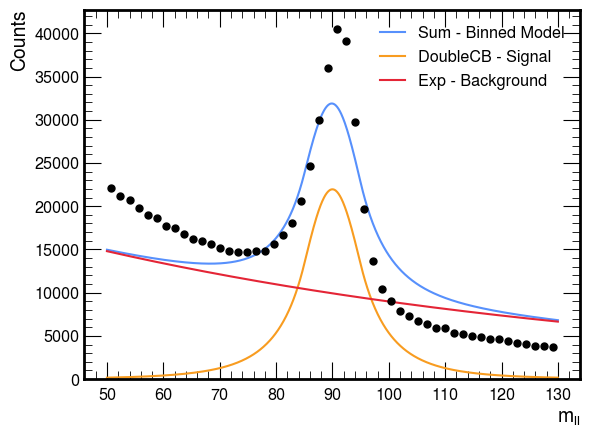

name      value  (rounded)    at limit
------  ------------------  ----------
n_sig               214350       False
n_bkg               513337       False
mu                 91.1167       False
sigma              3.12577       False
alphal            0.639034       False
nl                 14.6379       False
alphar             1.42469       False
nr                 6.19151       False
lambda          -0.0230971       False


/Users/iason/miniforge3/envs/work/lib/python3.11/site-packages/zfit/minimizers/fitresult.py:1204: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


True


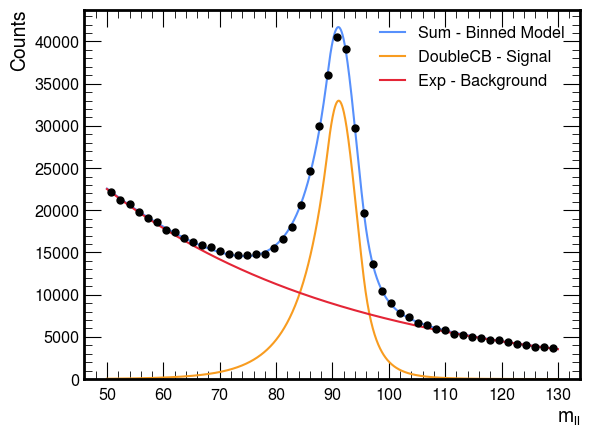

CPU times: user 3.7 s, sys: 144 ms, total: 3.85 s
Wall time: 3.49 s


In [6]:
%%time

# create NLL
nll = zfit.loss.ExtendedBinnedNLL(model=model, data=data)

# create a minimizer
minimizer = zfit.minimize.Minuit(mode=1)

plot_pdf("before fit")

result = minimizer.minimize(nll)
print(result.params)
# do the error calculations, first with hesse, then with minos
param_hesse = result.hesse()
# param_errors, _ = result.errors()
print(result.valid)  # check if the result is still valid

# plot the data

plot_pdf("after fit")

In [7]:
result.params["n_sig"]["value"] + result.params["n_bkg"]["value"]

727687.2122566915

In [8]:
h.sum()

727686.0

In [9]:
model_unbinned.params

{'frac_0': <zfit.ComposedParameter 'Composed_autoparam_1' params=[('sum_yields', 'Composed_autoparam_0'), ('yield_', 'n_sig')] value=0.2946>,
 'frac_1': <zfit.ComposedParameter 'Composed_autoparam_2' params=[('sum_yields', 'Composed_autoparam_0'), ('yield_', 'n_bkg')] value=0.7054>}

In [10]:
result.info

{'n_eval': 1243,
 'minuit': ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6.389e+06                 │             Nfcn = 1320              │
│ EDM = 0.00375 (Goal: 0.001)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬─────────